# Using pretrained MobileNetV2

Here we want to use a pre-trained mobile net and train it on the hand images from before. If we use the model already implemented in keras, we can use the weights from ImageNet.

# importing libraries

In [106]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model
#from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

from PIL import Image # used for loading images
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
#from IPython.display import Image
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt


In [14]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\werth\\AppData\\Local\\Continuum\\anaconda3\\envs\\workshop\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


# The model
## Loading the mobileNet model without top

In [118]:
#base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model=ResNet50(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5,seed=42)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

#specify the inputs
#specify the outputs
model=Model(inputs=base_model.input,outputs=preds)
#now a model has been created based on our architecture

C:\Users\werth\AppData\Local\Continuum\anaconda3\envs\workshop\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## visualize models to compare with and without top

In [132]:
for i,layer in enumerate(model.layers):
   #print(i,layer.name)
    1

Just for comparison, the original mobileNetV2 below

In [134]:
compare_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
for i,layer in enumerate(compare_model.layers):
    #print(i,layer.name)
    1

C:\Users\werth\AppData\Local\Continuum\anaconda3\envs\workshop\lib\site-packages\keras_applications\mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [119]:
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png')
1

1

## What happens when removing the last dense layers (on top)?

the weights in a convolutional layer are fixed-size. They are the size of the kernel x filters. Example: a 3x3 kernel of 10 filters. A convolutional layer doesn't care about the size of the input image. It just does the convolutions and present a resulting image based on the size of the input image. (Search for some illustrated tutorials about convolutions if this is unclear)

now the weights in a dense layer are totally dependent on the input size. It's one weight per element of the input. So this demands that your input be always the same size, or else you won't have proper learned weights.

Because of this, removing the final dense layers allows you to define the input size (see in documentation). (And the output size will increase/decrease accordingly)

Thanks to great stackoverflower [Daniel Möller](https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller)

## Fixing the layers to not be trainable

The model is set up like a numpy array where you can reach each layer by itself. You can set now all layers of the base model frozen.
important is that after setting layer trainable =False, the model has to `be compile()` to take effect.


See Keras [webside](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)

In [120]:
n=173 #154 are all layers before dense output
for layer in model.layers[:n]:
    layer.trainable=False
for layer in model.layers[n:]:
    layer.trainable=True

In [128]:
opt = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])



For optimal throughput you can use a double-buffering approach where the next request is already being prepared (by the CPU) while the current one is still being processed (by the GPU). This way the CPU and GPU are never waiting for one another.

---

# Training model
## Loading the data with data generator

Now we use the generator function again to load the data for training

In [137]:
datagen =ImageDataGenerator(rescale=1.0/255.0)

#datadirectory='E:/fotos/haende/gen_structured/input/'
#Tsize=[512,512]
datadirectory='C:/Users/werth/Pictures/small_structured/input/'
Tsize=[255,170]
 
train_batch_generator =datagen.flow_from_directory(directory=datadirectory + "Train/",
                                     classes=['Faust', 'Offen'],
                                     target_size=Tsize,
                                     class_mode='categorical',
                                     batch_size=10,
                                     color_mode='rgb',
                                     shuffle=True,
                                     seed=42)

valid_batch_generator =datagen.flow_from_directory(directory=datadirectory + "Test/",
                                     classes=['Faust', 'Offen'],
                                     target_size=Tsize,
                                     class_mode='categorical',
                                     batch_size=5,
                                     color_mode='rgb',
                                     shuffle=True,
                                     seed=42)

#img_batch = next(batches)



Found 242 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


## Training the model

In [129]:
%%time
step_size_train=train_batch_generator.n//train_batch_generator.batch_size
step_size_valid=valid_batch_generator.n//valid_batch_generator.batch_size

history=model.fit_generator(generator=train_batch_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_batch_generator,
                    epochs=10,
                    callbacks=[tensorboard_callback])

Epoch 1/10
24/24 [==============================] - 63s 3s/step - loss: 0.1519 - accuracy: 0.9483 - val_loss: 0.6930 - val_accuracy: 0.4231
Epoch 2/10
24/24 [==============================] - 60s 3s/step - loss: 0.0739 - accuracy: 0.9914 - val_loss: 0.6931 - val_accuracy: 0.4423
Epoch 3/10
24/24 [==============================] - 58s 2s/step - loss: 0.1188 - accuracy: 0.9526 - val_loss: 0.6940 - val_accuracy: 0.4615
Epoch 4/10
24/24 [==============================] - 61s 3s/step - loss: 0.1602 - accuracy: 0.9397 - val_loss: 0.6906 - val_accuracy: 0.5962
Epoch 5/10
14/24 [================>.............] - ETA: 20s - loss: 0.0679 - accuracy: 0.9773

KeyboardInterrupt: 

# Evaluating the model 

## Tensorboard

before training the model we activate tensorboard. Tensorboard can monitor the training and validation of the model and visualize the process. Thereby we can identify where optimization is needed.

you can load the tensorboard in another tab

In [63]:
def tb(logdir="logs", port=6006, open_tab=True, sleep=2):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port), shell=True)
    if open_tab:
        import time
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

server1=tb()               # Starts a TensorBoard server on the logs directory, on port 6006
                           # and opens a new tab in your browser to use it.

#server2=tb("logs2", 6007)  # Starts a second server on the logs2 directory, on port 6007,
                            # and opens a new tab to use it.

In [56]:
# and later...
server1.kill()  # stops the first server  

Or you can use the Tensorboard within jupyter notebook with the new Tensorflow2. It depends on your preferrence what suits your style better

In [140]:
import datetime, os
%load_ext tensorboard.notebook

logs_base_dir = ".\logs"#create folder for 
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

To kill a Tensorboard in Windows use CMD : taskkill /IM "tensorboard.exe" /F

Alternatively you can also use a file writer and save the information in the folder. Than you can call the tensorboard via the console and open tensorboard in another tab

In [139]:
writer = tf.summary.FileWriter( "./logs", tf.get_default_graph())
%tensorboard --logdir=.\logs

AttributeError: module 'tensorboard.summary._tf.summary' has no attribute 'FileWriter'

# Simply printing the history

In [31]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


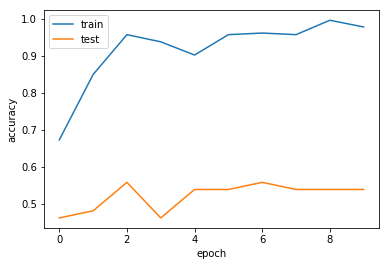

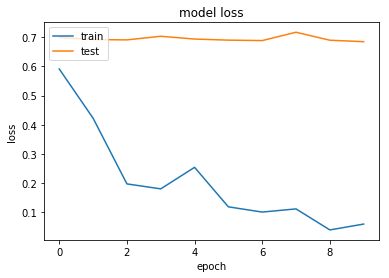

In [116]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()